<center>
<img src="../../img/ml_theme.png">
# Дополнительное профессиональное <br> образование НИУ ВШЭ
#### Программа "Практический анализ данных и машинное обучение"
<img src="../../img/faculty_logo.jpg" height="240" width="240">
## Автор материала: преподаватель Факультета Компьютерных Наук НИУ ВШЭ <br> Кашницкий Юрий
</center>
Материал распространяется на условиях лицензии <a href="https://opensource.org/licenses/MS-RL">Ms-RL</a>. Можно использовать в любых целях, кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Занятие 7. Задача Обучение без учителя
## <center>Практика. Кластеризация данных с акселерометров и гироскопов мобильных телефонов

**Считываем <a href="https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones">данные</a> Samsung Human Activity Recognition. Они же есть [тут](https://yadi.sk/d/ha-lprkDvozGx).**

In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
%pylab inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans

Populating the interactive namespace from numpy and matplotlib


**Считаем данные, объединим обучающую и тестовую выборки. Метки целевого класса будем использовать для оценки качества кластеризации. Конечно, kMeans не будет ничего о них "знать".**

In [3]:
X_train = np.loadtxt("../../data/samsung_train.txt") 
X_test = np.loadtxt("../../data/samsung_test.txt") 

y_train = np.loadtxt("../../data/samsung_train_labels.txt").astype(int)
y_test = np.loadtxt("../../data/samsung_test_labels.txt").astype(int)

**Для кластеризации объединим выборки.**

In [4]:
X = np.vstack([X_train, X_test])
y = np.hstack([y_train, y_test])

**Опеределим число уникальных значений меток целевого класса. Эти метки соответствуют ходьбе (1), подъему вверх по лестнице (2), спуску по лестнице (3), сидению (4), стоянию (5) и лежанию (6). [Описание](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.names)**

In [5]:
n_classes = len(np.unique(y))
n_classes

6

**Понижаем размерность с помощью PCA, оставляя столько компонент, сколько нужно для того, чтобы объяснить 90% дисперсии.**

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_pca = PCA(n_components=0.9).fit_transform(X_scaled)
X_pca.shape

(10299, 65)

**Визуализируем данные в проекции на первые две главные компоненты. Отчетливо выделяются 2 группы активностей. Можно догадаться, какие именно.**

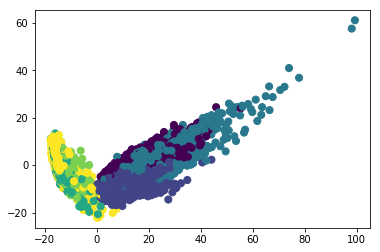

In [7]:
scatter(X_pca[:, 0], X_pca[:, 1], c=y, s=50, cmap='viridis');

**Сделайте кластеризацию данных (выделенных 65 главных компонент) методом KMeans. Задайте параметр *n_clusters*, равный *n_classes* - найденному ранее числу уникальных меток целевого класса.**

In [10]:
%%time
kmeans = KMeans(n_clusters=n_classes)
kmeans.fit(X_pca)
cluster_labels = kmeans.labels_

Wall time: 3.18 s


array([3, 3, 3, ..., 2, 2, 2])

**Визуализируйте данные в проекции на первые две главные компоненты. Раскрасьте точки в соответсвии с полученными метками кластеров.**

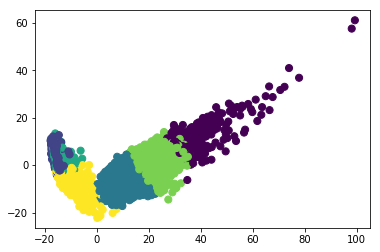

In [16]:
scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, s=50, cmap='viridis');

**Посмотрите на соответствие между метками кластеров и исходными метками классов. Посмотрите, какие виды активностей алгоритм KMeans путает.**

In [17]:
from pandas import crosstab
tab = crosstab(y, cluster_labels, margins=True)
tab.index = ['walk', 'up', 'down', 'sit', 'stand', 'lay', 'all']
tab.columns = ['cluster' + str(i) for i in range(n_classes)] + ['all']
tab

,cluster0,cluster1,cluster2,cluster3,cluster4,cluster5,all
walk,85,0,897,0,740,0,1722
up,9,0,1238,0,295,2,1544
down,214,0,309,0,883,0,1406
sit,0,90,1,1235,0,451,1777
stand,0,0,0,1340,0,566,1906
lay,0,1556,5,53,0,330,1944
all,308,1646,2450,2628,1918,1349,10299


**Посчитайте метрики качества кластеризации ARI, AMI, гомогенность, полноту и силуэт.**

In [19]:
from sklearn import metrics
         
print('ARI: %0.3f' % metrics.adjusted_rand_score(y, kmeans.labels_))
print('AMI: %0.3f' % metrics.adjusted_mutual_info_score(y, kmeans.labels_))
print('Homogeneity: %0.3f' % metrics.homogeneity_score(y, kmeans.labels_))
print('Completeness: %0.3f' % metrics.completeness_score(y, kmeans.labels_))
print('V-measure: %0.3f' % metrics.v_measure_score(y, kmeans.labels_))
print('Silhouette =: %0.3f' % metrics.silhouette_score(X_pca, kmeans.labels_, sample_size=1000))

ARI: 0.420
AMI: 0.541
Homogeneity: 0.541
Completeness: 0.579
V-measure: 0.559
Silhouette =: 0.141


**Видно, что kMeans хорошо отличает только группы активностей – 1 группа: walk, walk up, walk down, 2 группа: sit, stand, lay. Попробуйте искать не 6, а 2 кластера. Посмотрите теперь на качество кластеризации и прокомментируйте результат.**

In [22]:
y_walk = (y <= 3).astype('int')

In [23]:
%%time
kmeans2 = KMeans(n_clusters=2)
kmeans2.fit(X_pca)
two_clusters_labels = kmeans2.labels_

Wall time: 619 ms


In [24]:
tab2 = crosstab(y_walk, two_clusters_labels, margins=True)
tab2.index = ['walk/up/down', 'sit/stand/lay', 'all']
tab2.columns = ['cluster1', 'cluster2', 'all']
tab2

,cluster1,cluster2,all
walk/up/down,15,5612,5627
sit/stand/lay,4664,8,4672
all,4679,5620,10299


In [25]:
print('ARI: %0.3f' % metrics.adjusted_rand_score(y_walk, two_clusters_labels))
print('AMI: %0.3f' % metrics.adjusted_mutual_info_score(y_walk, two_clusters_labels))
print('Homogeneity: %0.3f' % metrics.homogeneity_score(y_walk, two_clusters_labels))
print('Completeness: %0.3f' % metrics.completeness_score(y_walk, two_clusters_labels))
print('V-measure: %0.3f' % metrics.v_measure_score(y_walk, two_clusters_labels))
print('Silhouette =: %0.3f' % metrics.silhouette_score(X_pca, two_clusters_labels, sample_size=1000))

ARI: 0.991
AMI: 0.977
Homogeneity: 0.977
Completeness: 0.977
V-measure: 0.977
Silhouette =: 0.435


### Многоклассовая классификация
**Видим, что выделять 6 кластеров на этих данных хорошо не получается. Хорошо отделяются только ходьба (простая, вверх и вниз) от остальных активностей. Зато задача неплохо решается как задача классификации.**

In [26]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

**Отмасштабируйте выборку X_train, выделите в ней столько главных компонент, чтоб оставить 90% дисперссии, проведите соответсвующее преобразование с тестовой выборкой X_test**

In [39]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
pca = PCA(n_components=0.9)
X_train_pca = pca.fit_transform(X_train_scaled)
print(X_train_pca.shape)

X_test_scaled = scaler.transform(X_test)
X_test_pca = pca.transform(X_test_scaled)
print(X_test_pca.shape)

(7352, 63)
(2947, 63)


**Будем обучать лес на исходных признаках и на главных компонентах.**

In [40]:
forest = RandomForestClassifier(n_estimators=100, 
                                random_state=7, n_jobs=-1,
                                oob_score=True)
forest_pca = RandomForestClassifier(n_estimators=100, 
                                random_state=7, n_jobs=-1,
                                oob_score=True)

**Обучите лес на главных компонентах, посмотрите OOB-оценку качества.**

In [42]:
forest_pca.fit(X_train_pca, y_train)
forest_pca.oob_score_

0.92736670293797607

**Обучите лес на всех признаках, посмотрите OOB-оценку качества.**

In [43]:
forest.fit(X_train_scaled, y_train)
forest.oob_score_

0.98245375408052227

**Сравните качество (долю правильных ответов и F1 с макро-усреднением) на тестовой выборке для леса, обученного на всех признаках, и для леса, обученного на главных компонентах. Посмотрите также на матрицы ошибок.**

In [44]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

In [45]:
forest_pca_pred = forest_pca.predict(X_test_pca)
print(accuracy_score(y_test, forest_pca_pred))
print(f1_score(y_test, forest_pca_pred, average='macro'))

0.874787919919
0.871158219546


In [46]:
confusion_matrix(y_test, forest_pca_pred)

array([[474,   1,  21,   0,   0,   0],
       [ 33, 425,  13,   0,   0,   0],
       [ 62,  46, 312,   0,   0,   0],
       [  0,   1,   0, 367, 121,   2],
       [  0,   0,   0,  42, 490,   0],
       [  0,   0,   0,  25,   2, 510]])

In [47]:
forest_pred = forest.predict(X_test)
print(accuracy_score(y_test, forest_pred))
print(f1_score(y_test, forest_pred, average='macro'))

0.299966067187
0.202599368081


In [48]:
confusion_matrix(y_test, forest_pred)

array([[160,   0,   0, 269,  67,   0],
       [ 37,   1,   0, 286, 147,   0],
       [249,   0,   0, 128,  43,   0],
       [  0,   0,   0, 233, 258,   0],
       [  0,   0,   0,  42, 490,   0],
       [  0,   0,   0, 535,   2,   0]])

**Проверьте аналогично линейный SVM на всех признаках. Настройте параметр C с помощью GridSearchCV.**

In [49]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

In [50]:
svm = LinearSVC()
svm_params = {'C': np.logspace(-2, 2, 10)}

In [52]:
best_svm = GridSearchCV(svm, svm_params, verbose=1, n_jobs=-1)

In [54]:
best_svm.fit(X_train_scaled, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  2.7min finished


In [56]:
svm_pred = best_svm.predict(X_test_scaled)

In [57]:
print(accuracy_score(y_test, svm_pred))
print(f1_score(y_test, svm_pred, average='macro'))

0.962334577536
0.963187796047


In [58]:
confusion_matrix(y_test, svm_pred)

array([[493,   2,   0,   1,   0,   0],
       [ 13, 457,   1,   0,   0,   0],
       [  2,   4, 413,   1,   0,   0],
       [  0,   4,   0, 431,  56,   0],
       [  0,   0,   0,  16, 516,   0],
       [  0,   0,   0,   0,  11, 526]])